In [1]:
# (c) Charles Le Losq 2023
# see embedded licence file
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#
# Library loading and additional function definition
#
%matplotlib inline

# dataframes and arrays
import pandas as pd 
import numpy as np
#import seaborn as sns

# for plotting
import matplotlib.pyplot as plt 

import time, h5py
import src.utils as utils
import src.ivisc as ivisc

used_library = "gpflow"



/var/folders/23/p99d2kmd0vlg5qrqb4vq2q840000gn/T/ipykernel_45832/1136458127.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-04 17:39:00.399566: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Function for the effect of crystals

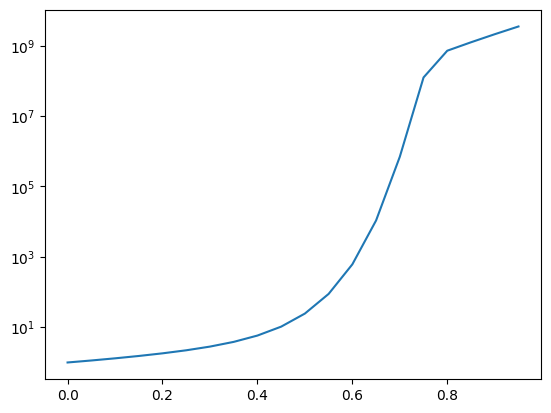

In [2]:
#
# COSTA 2009 EQUATION FOR CRISTALS
# VALUES FOR MORB (6)
from scipy.special import erf

def C2009(phy, 
               xi = 0.1e-4, 
               gamma = 3.429, 
               B = 2.5, 
               phy_star = 0.622):
    
    delta = 13 - gamma
    r_phy = phy/phy_star
    
    F = (1-xi)*erf(np.sqrt(np.pi)/(2*(1-xi)) * r_phy * (1+r_phy**gamma))
    eta_r = (1+r_phy**delta) / ((1-F)**(B*phy_star))
    
    return eta_r

def test_sig(n_start, T, phy, n_high = 21.0, phy_m=0.622, slope=15):
    
    # final viscosity vector
    n_ = n_start.copy()
    
    # we get the effect of crystals on the melt viscosity before the rheological transition
    effet_ctx = np.log10(C2009(phy[phy<phy_m], phy_star=phy_m))
    n_[phy<phy_m] = n_[phy<phy_m].copy() + np.nan_to_num(effet_ctx)
    
    n_[phy>=phy_m] = np.log10(eta_mantle(T[phy>=phy_m], phy[phy>=phy_m]))
    # add the viscosity of the solid mantle affected by melt (after rheological transition)
    #ctx_ = 1/(1 + np.exp(slope*(-phy[phy>=phy_m]+phy_m)))
    #n_[phy>=phy_m] = np.log10(eta_mantle(T, phy)) #ctx_*(n_high-trans) + trans
    return n_

def eta_mantle(T, phy_solid, Ea = 250.0e3, no = 10**21., To = 1400.0, sigma_sil=21.):
    f_phy = np.exp(-sigma_sil*(1-phy_solid))
    term2 = np.exp(Ea/8.314*(1./T-1./To))
    n = no*f_phy*term2
    return n

import astropy.units as u
from astropy.constants import G, h, k_B, c

###
# TEMPERATURE 
###
def calculate_T_surface(longitude = np.arange(-180,180,1)*u.degree, 
                        epsilon_5_over_2 = 1.0,
                        R_star = 0.943*u.solRad,
                        d_star = 0.01544*u.AU,
                        T_star = 5172.0*u.Kelvin,
                        nightside_T = 1045.0*u.Kelvin):

    T_surf = (epsilon_5_over_2**0.25) *((R_star.si/d_star.si)**0.5)*(np.cos(longitude.si)**0.25)*T_star
    T_surf = np.nan_to_num(T_surf,0)
    T_surf[T_surf < nightside_T] = nightside_T
    return T_surf
    
phy = np.arange(0,1,0.05)

plt.plot(phy, C2009(phy))
plt.yscale('log')

# WITH PAOLO DATA + 55 CANCRI MAP
# LONGITUDINAL PROFILE

In [3]:
# 1 bar + 1°-4 bar glued
compo_1bar_A = pd.read_excel("./data/dev/Condensation_BSE_Liquid_Compositions.xlsx", sheet_name="all_1bar")
compo_1bar_A["prct_c"] = 100 -compo_1bar_A["prct_l"]-compo_1bar_A["prct_g"] 
mo_compo_1bar_A = utils.descriptors(pd.DataFrame(compo_1bar_A, 
                                          columns=["sio2", "tio2", "al2o3", "feo", "fe2o3", "mno", 
                                                   "na2o", "k2o", "mgo", "cao", "p2o5", "h2o"]))
nbot_1bar_A = mo_compo_1bar_A["nbot"]
nbot_1bar_A[nbot_1bar_A < 0] = 0
mo_compo_1bar_A = mo_compo_1bar_A.values

# again, we use a nearest neighbor algo to link temperature to all other variables:

from sklearn.neighbors import KNeighborsRegressor

# we use a nearest neighbors algorithm to map RGB to fraction
clf = KNeighborsRegressor(n_neighbors=1, weights='distance')
clf.fit(compo_1bar_A.loc[:, "T_K"].values.reshape(-1,1), 
        compo_1bar_A.loc[:, ["sio2", "tio2", "al2o3", "feo", "fe2o3", 
                             "mno", "na2o", "k2o", "mgo", "cao", "p2o5", 
                             "h2o", 'prct_c', 'prct_l', 'prct_g']].values)

/var/folders/23/p99d2kmd0vlg5qrqb4vq2q840000gn/T/ipykernel_45832/531688620.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbot_1bar_A[nbot_1bar_A < 0] = 0


KNeighborsRegressor(n_neighbors=1, weights='distance')

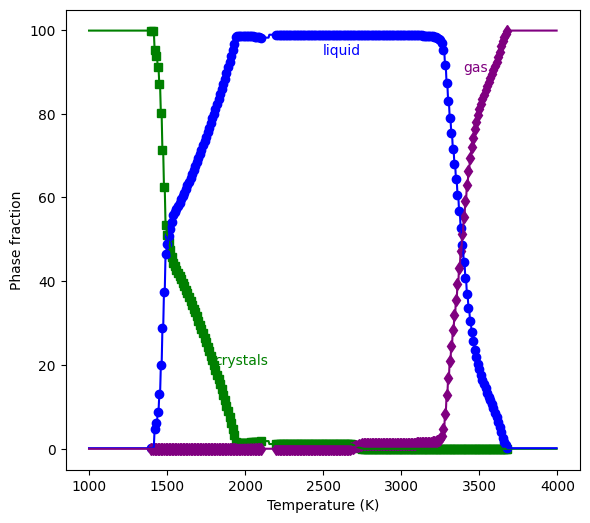

In [4]:
# plot with an inverse X scale T_K versus prcl_l in compo_1bar
plt.figure(figsize=(6,8/9*6))

plt.plot(compo_1bar_A["T_K"], compo_1bar_A["prct_c"], "s", color="green", label="1 bar")
plt.plot(compo_1bar_A["T_K"], compo_1bar_A["prct_l"], "o", color="blue", label="1 bar")
plt.plot(compo_1bar_A["T_K"], compo_1bar_A["prct_g"], "d", color="purple", label="1 bar")

# visualize the ML model
fake_T = np.arange(1000,4000,5.0)
plt.plot(fake_T, clf.predict(fake_T.reshape(-1,1))[:,12], "-", color="green")
plt.plot(fake_T, clf.predict(fake_T.reshape(-1,1))[:,13], "-", color="blue")
plt.plot(fake_T, clf.predict(fake_T.reshape(-1,1))[:,14], "-", color="purple")

#plt.plot(compo_100microbar["T_K"], compo_100microbar["prct_l"], "-", color="r", label="100 microbar")
#plt.plot(compo_100microbar["T_K"], compo_100microbar["prct_g"], "--", color="r", label="100 microbar")
#plt.plot(compo_100microbar["T_K"], compo_100microbar["prct_c"], ":", color="r", label="100 microbar")

plt.annotate("liquid", xy=[2500,94], color="blue")
plt.annotate("gas", xy=[3400,90], color="purple")
plt.annotate("crystals", xy=[1800,20], color="green")

#plt.annotate("liquid\n1 bar", xy=[1860,80], color="red")
#plt.annotate("gas\n1 bar", xy=[2300,85], color="red")
#plt.annotate("crystals\n1 bar", xy=[1450,90], color="red")

# add legend
plt.xlabel("Temperature (K)")
plt.ylabel("Phase fraction")
plt.tight_layout()
# add predicted liquidus
#T_liquidus_1bar_A = neuralmodel.predict("liquidus", mo_compo_1bar_A, sampling=True, n_sample=n_sample)


## Now we predict the composition, and various fractions for 55 CAncri e. All is saved in a Pandas dataframe and sent to the right folder.

/Users/charleslelosq/anaconda3/envs/gpflow/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(360,)


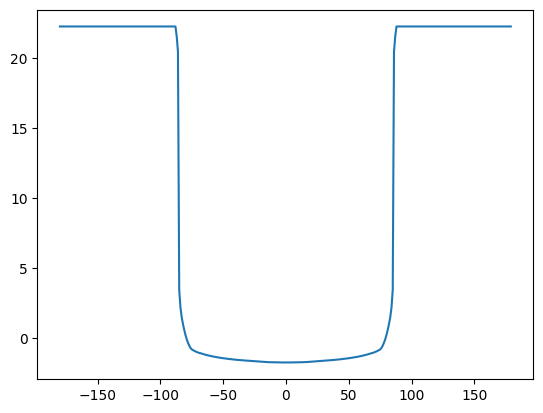

In [5]:
#T_cancri = np.load("./data/T_cancri.npy")
#Longitude_axis = np.linspace(-109.8, 109.8, len(T_cancri))

Longitude_axis = np.arange(-180,180,1.0)
T_cancri = calculate_T_surface(nightside_T=1232.0*u.Kelvin).to_value()

print(T_cancri.shape)
values_cancri = clf.predict(T_cancri.reshape(-1,1))
Cancri_compo = pd.DataFrame(values_cancri, columns= ['sio2', "tio2", 'al2o3', "feo", "fe2o3", "mno", 
                                                     'na2o', 'k2o', 'mgo', 'cao', "p2o5", "h2o", 'prct_c', 'prct_l', 'prct_g'])

used_library = "gpflow"
if used_library == "gpjax":
    import joblib
    from sklearn.preprocessing import StandardScaler
    from jax import config
    
    config.update("jax_enable_x64", True)
    
    from jax import jit
    import jax.numpy as jnp
    import jax.random as jr
    from jaxtyping import install_import_hook
    with install_import_hook("gpjax", "beartype.beartype"):
        import gpjax as gpx
        
    opt_posterior = joblib.load("./models/GP_model_kernel5_trainvalidjoined.gz")
    
    ds = utils.data_loader(path_viscosity='./data/all_viscosity.hdf5')
    X_train = np.concatenate((1000/ds.T_train, ds.P_train, ds.X_train[:,0:12]), axis=1).copy()
    X_valid = np.concatenate((1000/ds.T_valid, ds.P_valid, ds.X_valid[:,0:12]), axis=1).copy()
    Y_train = ds.y_train.copy()/10
    Y_valid = ds.y_valid.copy()/10
    # joint valid and train
    X_train = np.concatenate((X_train,X_valid))
    Y_train = np.concatenate((Y_train,Y_valid))
    #scale
    X_scaler = StandardScaler()
    X_train_sc = X_scaler.fit_transform(X_train)
    # dataset for GP
    D = gpx.Dataset(X=X_train_sc, y=Y_train)

    # putting together and scaling data
    Cancri_input = np.concatenate((1000/T_cancri.reshape(-1,1),
                                  np.zeros((len(T_cancri),1)),
                                  Cancri_compo.loc[:,['sio2', "tio2", 'al2o3', "feo", "fe2o3", "mno", 
                                                         'na2o', 'k2o', 'mgo', 'cao', "p2o5", "h2o"]].values), axis=1)
    Cancri_input_sc = X_scaler.transform(Cancri_input)
    
    preds_latent_dist = opt_posterior(Cancri_input_sc, train_data=D)
    preds_predictive_dist = opt_posterior.posterior.likelihood(preds_latent_dist)
    
    Cancri_visco_melt = preds_predictive_dist.mean()
    preds_predictive_std = preds_predictive_dist.stddev()

elif used_library == "gpflow":
    import tensorflow as tf
    opt_posterior = tf.saved_model.load("./models/GP_Mater32_poly")
    
    Cancri_input = np.concatenate((1000/T_cancri.reshape(-1,1),
                                  np.zeros((len(T_cancri),1)),
                                  Cancri_compo.loc[:,['sio2', "tio2", 'al2o3', "feo", "fe2o3", "mno", 
                                                         'na2o', 'k2o', 'mgo', 'cao', "p2o5", "h2o"]].values), axis=1)

    Cancri_pr_visco_mean, Cancri_pr_visco_var = opt_posterior.compiled_predict_y(Cancri_input)
    Cancri_pr_visco_mean = Cancri_pr_visco_mean.numpy().ravel()
    Cancri_pr_visco_var = Cancri_pr_visco_var.numpy().ravel()
elif used_library == "keras":

    ds = utils.data_loader(path_viscosity='./data/all_viscosity.hdf5')
    model_1 = tf.keras.models.load_model('./models/model1_best.keras', 
                                     custom_objects={'MyegaCalculationLayer_model1': ivisc.MyegaCalculationLayer_model1})

    Cancri_compo_greybox = utils.descriptors(pd.DataFrame(Cancri_compo, 
                                                columns=['sio2', "tio2", 'al2o3', "feo", "fe2o3", "mno", 
                                                         'na2o', 'k2o', 'mgo', 'cao', "p2o5", "h2o"])).values

    pxi_scaled = ds.scale_for_gb1(Cancri_compo_greybox, 
                                  np.zeros((len(T_cancri),1)))
    Cancri_pr_visco_mean = model_1.predict((pxi_scaled, T_cancri.reshape(-1,1))).ravel()

#
#Cancri_visco_melt = neuralmodel.predict("tvf", Cancri_compo_imelt, T=T_cancri.reshape(-1,1))

#Cancri_effet_ctx = np.log10(C2009(Cancri_compo.prct_c/100))

Cancri_visco = test_sig(np.array(Cancri_pr_visco_mean.tolist()), T_cancri, Cancri_compo.prct_c.values/100)

Cancri_compo["Cancri_visco"] = Cancri_visco

Cancri_compo.to_csv("./data/Cancri_calcul.csv")



plt.plot(Longitude_axis, Cancri_visco)
#plt.ylim(-3,1)

# NOW WE DO THE SAME FOR A CaO-Al2O3 magma ocean
87% Al2O3
13 % CaO 
Léger et al. 2011

Viscosity of this mixture:

In [69]:
CA_compo = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0., 0.0, 0.0]) # Léger 2011

CA_compo = utils.descriptors(pd.DataFrame(CA_compo.reshape(1,-1), 
                                          columns=["sio2", "tio2", "al2o3", "feo", "fe2o3", "mno", 
                                                   "na2o", "k2o", "mgo", "cao", "p2o5", "h2o"]))


Cancri_input = np.concatenate((1000.0/(np.ones((1,1))*2500.0),
                                  np.zeros((1,1)),
                                  CA_compo.loc[:,['sio2', "tio2", 'al2o3', "feo", "fe2o3", "mno", 
                                                         'na2o', 'k2o', 'mgo', 'cao', "p2o5", "h2o"]].values), axis=1)

Cancri_ca_visco_mean, Cancri_ca_visco_var = opt_posterior.compiled_predict_y(Cancri_input)
print(Cancri_ca_visco_mean)
print(Cancri_ca_visco_var)

tf.Tensor([[-1.51046157]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.10410748]], shape=(1, 1), dtype=float64)


### Now the evolution as a function of T_cancri

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51779D+04    |proj g|=  1.57240D+04

At iterate   20    f=  1.67307D+02    |proj g|=  4.37651D-02
  ys=-2.090E+02  -gs= 2.406E+01 BFGS update SKIPPED

At iterate   40    f=  4.86455D+01    |proj g|=  6.51623D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     44     76      1     1     0   1.429D-06   4.864D+01
  F =   48.644228661586375     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


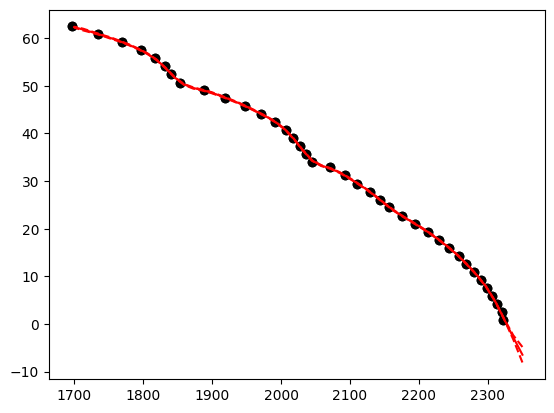

In [15]:
# import CA liquidus
liquidus_cao_al2o3 = np.genfromtxt("./data/Liquidus_CaO_Al2O3.csv", delimiter=",")
liquidus_cao_al2o3 = np.copy(liquidus_cao_al2o3[liquidus_cao_al2o3[:,0]<64,:])

import gpflow

# create GP model
kernel = gpflow.kernels.Matern32(variance=.01)
model_liquidus = gpflow.models.GPR(
        (liquidus_cao_al2o3[:,1].reshape(-1,1), liquidus_cao_al2o3[:,0].reshape(-1,1)), kernel=kernel)

# fit hyperparameters
opt = gpflow.optimizers.Scipy()
opt.minimize(model_liquidus.training_loss, 
             model_liquidus.trainable_variables,
            options={"disp": 20, "maxiter": 100})


# make predictions
T_cao_interp = np.linspace(2350,1700,50)
liquidus_preds = model_liquidus.predict_y(T_cao_interp.reshape(-1,1))

# plot GP model
plt.plot(liquidus_cao_al2o3[:,1].reshape(-1,1), liquidus_cao_al2o3[:,0].reshape(-1,1),"ko")
plt.plot(liquidus_cao_al2o3[:,1].reshape(-1,1), liquidus_cao_al2o3[:,0].reshape(-1,1),"ko")
plt.plot(T_cao_interp,liquidus_preds[0],"r-")
plt.plot(T_cao_interp,liquidus_preds[0]+liquidus_preds[1],"r--")
plt.plot(T_cao_interp,liquidus_preds[0]-liquidus_preds[1],"r--")

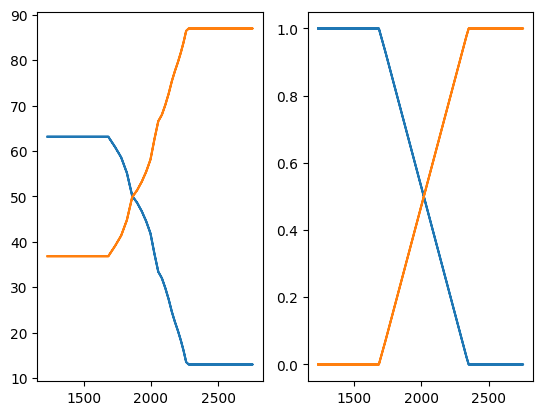

In [47]:
# Melt composition

CaO_min = 13.0 #wt%

CA_concentration = model_liquidus.predict_y(T_cancri.reshape(-1,1))[0].numpy()
CA_concentration[CA_concentration<=CaO_min] = CaO_min
CA_concentration[T_cancri<1413+273] = (1-7/(12+7.0))*100

AL2O3_concentration = 100-CA_concentration

# Cristal content
ct_CA = np.polyfit(np.array([1413+273, 2350]), 
                  np.array([1, 0.0]),1)

CA_prct_c = np.polyval(ct_CA, T_cancri)
CA_prct_c[T_cancri<1413+273] = 1.0
CA_prct_c[T_cancri>2350] = 0.0
CA_prct_l = 1-CA_prct_c

plt.subplot(1,2,1)
plt.plot(T_cancri,CA_concentration)
plt.plot(T_cancri,AL2O3_concentration)

plt.subplot(1,2,2)
plt.plot(T_cancri, CA_prct_c)
plt.plot(T_cancri, CA_prct_l)



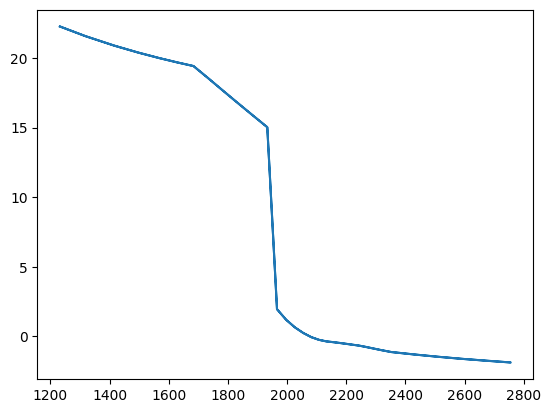

In [68]:
out = np.zeros((len(T_cancri), len(utils.list_oxides())))
out[:,2] = AL2O3_concentration.ravel()
out[:,9] = CA_concentration.ravel()

df = utils.chimie_control(pd.DataFrame(out, columns=utils.list_oxides()))
Cancri_CA_compo = utils.descriptors(df.loc[:, utils.list_oxides()])

if used_library == "gpflow":
    import tensorflow as tf
    opt_posterior = tf.saved_model.load("./models/GP_Mater32_poly")
    
    Cancri_input = np.concatenate((1000/T_cancri.reshape(-1,1),
                                  np.zeros((len(T_cancri),1)),
                                  Cancri_CA_compo.loc[:,['sio2', "tio2", 'al2o3', "feo", "fe2o3", "mno", 
                                                         'na2o', 'k2o', 'mgo', 'cao', "p2o5", "h2o"]].values), axis=1)

    Cancri_ca_visco_mean, Cancri_ca_visco_var = opt_posterior.compiled_predict_y(Cancri_input)
    Cancri_ca_visco_mean = Cancri_ca_visco_mean.numpy().ravel()
    Cancri_ca_visco_var = Cancri_ca_visco_var.numpy().ravel()
    
Cancri_visco_CA = test_sig(Cancri_ca_visco_mean, T_cancri, CA_prct_c)

plt.plot(T_cancri, Cancri_visco_CA, "-")

Cancri_CA_compo = Cancri_CA_compo.loc[:, utils.list_oxides()].copy()
Cancri_CA_compo["prct_l"] = CA_prct_l.copy()
Cancri_CA_compo["prct_c"] = CA_prct_c.copy()
Cancri_CA_compo["Cancri_visco"] = np.copy(Cancri_visco_CA)

Cancri_CA_compo.to_csv("./data/Cancri_calcul_CA.csv")

# ATTEMPT OF MAPS

In [63]:
# Composition
# number of compositional points
nb_points = 100

# compositions : CA and pyrolite
pyrolite_compo = np.array([0.4540, 0.0449, 0.00259, 0.00026, 0.3677, 0.0365+0.0810]).reshape(1,6) # Palme et O'Neill
# convert to mol
pcm = pd.DataFrame(pyrolite_compo, columns = ["sio2", "al2o3", "na2o", "k2o", "mgo", "cao"])
pcm = vp.chimie_control(pcm)
pcm = vp.wt_mol(pcm)
pyrolite_compo_mol = pcm.loc[:,["sio2", "al2o3", "na2o", "k2o", "mgo", "cao"]].values
CA_compo = np.array([0.0, 0.87, 0.0, 0.0, 0.0, 0.13]) # Léger 2011

# mixing both : we go from CA to pyrolite
x_mix = np.linspace(0,1,nb_points).reshape(-1,1)
mo_compo = x_mix*pyrolite_compo_mol + (1-x_mix)*CA_compo

# put compositions with good descriptors
pyrolite_compo = utils.descriptors(pd.DataFrame(pyrolite_compo_mol.reshape(1,-1), 
                                                columns=["sio2", "al2o3", "na2o", "k2o", "mgo", "cao"])).values
CA_compo = utils.descriptors(pd.DataFrame(CA_compo.reshape(1,-1), 
                                          columns=["sio2", "al2o3", "na2o", "k2o", "mgo", "cao"])).values
mo_compo = utils.descriptors(pd.DataFrame(mo_compo, 
                                          columns=["sio2", "al2o3", "na2o", "k2o", "mgo", "cao"])).values

long = np.arange(-180, 190, 10)
lat = np.arange(-90,100, 10)
pos = np.dstack((x, y))

from scipy.stats import multivariate_normal
rv = multivariate_normal([0.0, 0.0], [[1000, 0.], [0., 500.]])
T = rv.pdf(pos)
T = T/np.max(T)*2000+1000

prop = T.copy()

for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        prop[i,j] = neuralmodel.predict("cg",
                                       pyrolite_compo,
                                       T=np.array(T[i,j]))

## Temperature profile

Text(0, 0.5, 'Latitude')

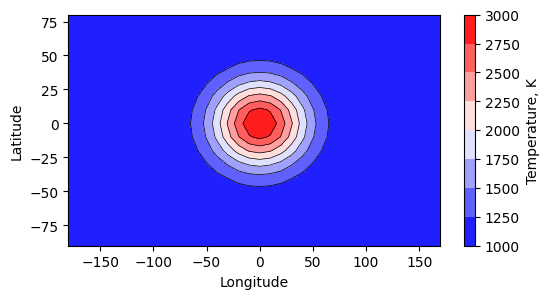

In [70]:
x, y = np.mgrid[-180:180:10., -90:90:10.]

fig2 = plt.figure(figsize=(6,3))

ax2 = fig2.add_subplot(111)

ax2.contour(x, y, T, colors="k", linewidths=0.5)
CS = ax2.contourf(x, y, T, cmap='bwr')
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig2.colorbar(CS)
cbar.set_label("Temperature, K")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

# Viscosity

Text(0, 0.5, 'Latitude')

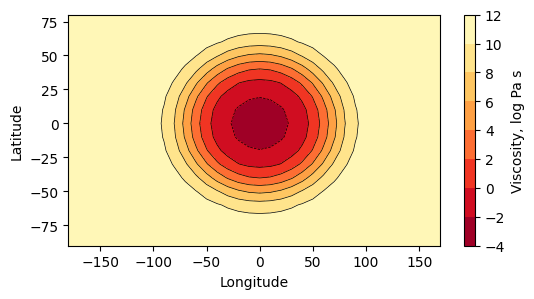

In [69]:
fig2 = plt.figure(figsize=(6,3))

ax2 = fig2.add_subplot(111)

ax2.contour(x, y, prop, colors="k", linewidths=0.5)
CS = ax2.contourf(x, y, prop, cmap="YlOrRd_r")

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig2.colorbar(CS)
cbar.set_label("Viscosity, log Pa s")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")